<a href="https://colab.research.google.com/github/Amruthakap3/AML/blob/main/face_recognition_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os
from pathlib import Path
from numpy import mean
from numpy import std
from os import listdir
from tqdm import tqdm


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D
from tensorflow.keras.optimizers import SGD    
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses

#Import CV2
import cv2
from PIL import Image
import pathlib


# Load The Data from Git Repo as Zip file

Load the zip file from git and unzip it, The data is already splited as train and test set. 

1.   There are 400 face images in the dataset
2.   Face images were taken at different times, variying ligthing, facial express and facial detail
3. All face images have black or gray background
4. The images are gray level but has 3 channel 
5. image size 48x48



In [ ]:
#Load the images from git as zip file
!rm  -rf *
!wget https://github.com/Amruthakap3/AML/raw/main/facesDB.zip
!unzip -qq facesDB.zip

#Define directory structure 
BASE_DIRECTORY = "facesDB"
TRAIN_DIRECTORY='facesDB/train'
TEST_DIRECTORY='facesDB/test'
IMAGES_PATH = './images/cnn'

--2022-03-18 18:57:29--  https://github.com/Amruthakap3/AML/raw/main/facesDB.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Amruthakap3/AML/main/facesDB.zip [following]
--2022-03-18 18:57:29--  https://raw.githubusercontent.com/Amruthakap3/AML/main/facesDB.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540968 (1.5M) [application/zip]
Saving to: ‘facesDB.zip’

facesDB.zip         100%[===================>]   1.47M  --.-KB/s    in 0.02s   

2022-03-18 18:57:30 (61.2 MB/s) - ‘facesDB.zip’ saved [1540968/1540968]



# Display an Image from Sample

(48, 48, 3)


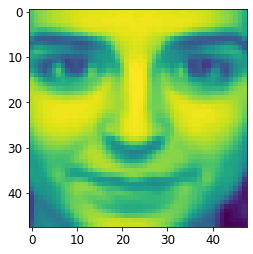

In [ ]:
#Display a sample pic from loaded data
def displayImage(path):
  filename = TRAIN_DIRECTORY+path
  pixels = plt.imread(filename)
  rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
  print(rgb_pixels.shape)
  plt.imshow(pixels)
  plt.show()

displayImage('/S10/5.BMP')  

# Utility Function’s 

In [ ]:
#Custom method to laod and preproces images
#This method return X, Y and labels
def load_data(dir_path, image_size):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in sorted(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + '/' + path):
                #Added to ignore some hidden files
                if(file =='Thumbs.db'): continue

                if not file.startswith('.'):
                    #Read image as IMREAD_GRAYSCALE
                    img = cv2.imread(dir_path + '/' + path + '/' + file, cv2.IMREAD_GRAYSCALE)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, image_size, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



#Plot some samples images
#Takes features(X) and Y(labels) and number of samples display as inputs
def plot_samples(X, y, labels_dict, n=10, number_of_samples=4):
   
    for index in range(len(labels_dict)):
        
        if(index == number_of_samples): break

        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0], cmap='gray')
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

#Load data
def load_dataset():
  return X_train, y_train, X_test, y_test       


# Load Data using custom data loading method 

In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIRECTORY, (48,48))
X_test, y_test, test_labels = load_data(TEST_DIRECTORY,(48,48))

print("Train X shape " + str(X_train.shape))
print("Train Y shape " + str(y_train.shape))
print("Test X shape " + str(X_test.shape))
print("Test Y shape " + str(y_test.shape))
print("Labels " + str(sorted(train_labels)))

320 images loaded from facesDB/train directory.
80 images loaded from facesDB/test directory.
Train X shape (320, 48, 48)
Train Y shape (320,)
Test X shape (80, 48, 48)
Test Y shape (80,)
Labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


# Display some sample images from Train & Test Data

Train Samples
------------------------------------------------------


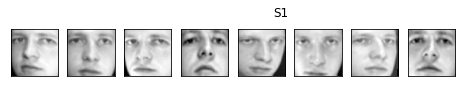

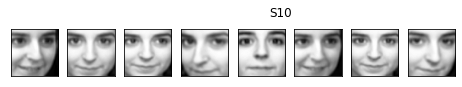

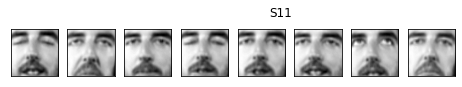

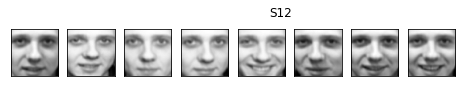




Test Samples
------------------------------------------------------


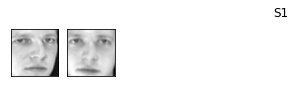

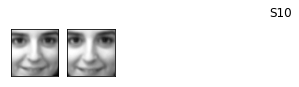

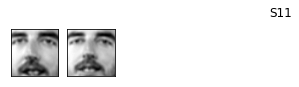

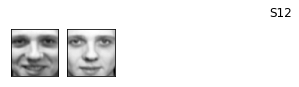

In [ ]:
print("Train Samples")
print("------------------------------------------------------")
plot_samples(X_train, y_train, train_labels, 30, 4)
print("\n\n")
print("Test Samples")
print("------------------------------------------------------")
plot_samples(X_test, y_test, test_labels, 30, 4)

# Reshape and encode the data

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
X_test = X_test.reshape((X_test.shape[0], 48, 48, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Evaluate the model using k-fold cross-validation

In [ ]:
run_index = 1
run_logdir = os.path.join(os.curdir, "fh_logs", "run_{:03d}".format(run_index))
run_logdir

'./fh_logs/run_001'

In [ ]:
# Evaluate the model using k-fold cross-validation
#inputs model, X, Y, number of foldes and filename to save the best model

def evaluate_model(model, dataX, dataY, n_folds, fname):

  scores, histories = list(), list()
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
  checkpoint_cb = keras.callbacks.ModelCheckpoint(fname, save_best_only=True)
  tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) 
 
	# prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
 
	# enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
  
		# select rows for train and test
	  trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

		# fit model
	  history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_data=(testX, testY), verbose=1, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
  
		# evaluate model
	  _, acc = model.evaluate(testX, testY, verbose=0)
	  print('CV Fold accuracy:  %.3f' % (acc * 100.0))
  
		# stores scores
	  scores.append(acc)
	  histories.append(history)
  
  return scores, histories

# Plot Training Summery



1.   Plot accuracy/loss
2.   Plot validation accuracy/loss



In [ ]:
def plot_training_summery(histories):
  for i in range(len(histories)):
		
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.legend(loc='lower right')
		
    # plot accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='red', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='green', label='test')
    plt.legend(loc='lower right')
  
    pyplot.show()

# Process the Model's

In [ ]:
def summarize_performance(scores):
	print('Model Accuracy: mean=%.3f std=%.3f, folds=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

In [ ]:
def process(model, num_folds, fileName):

	# load dataset
	trainX, trainY, testX, testY = load_dataset()
 
	# evaluate the model using CV
	scores, histories = evaluate_model(model, trainX, trainY, num_folds, fileName)
 
	# learning curves
	plot_training_summery(histories)
 
	# summarize estimated performance
	summarize_performance(scores)

In [ ]:
%pip install visualkeras
import visualkeras
def visualizeModel(model):
  # Draw model1's architecture  
  #visualkeras.layered_view(model1, to_file='output.png') # write to disk
  #visualkeras.layered_view(model1, to_file='output.png').show() # write and show
  visualkeras.layered_view(model)

# Create Model's

1.   Creating a very simple CNN model and train using custom loaded data
2.   Creating a CNN model with 3 Conv2D layers nd train using custom loaded data




In [ ]:
#Create the model_1
def create_compile_model_1():

  model = Sequential()
  model.add(Conv2D(64, (32, 32), activation='relu', kernel_initializer='he_uniform', input_shape=(48, 48, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Flatten())
  model.add(Dense(40, activation='softmax'))
  opt = SGD(lr=0.01, momentum=0.9)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [ ]:
#Create model_2

class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

def create_compile_model_2():
  
  # Define a sequential keras model
  model = Sequential()

  # 1st Convolution layer
  model.add(Conv2D(1024, kernel_size=(3, 3), activation='linear', input_shape=(48, 48, 1), padding='same'))
  model.add(MaxPooling2D((2, 2)))

  # 2nd Convolution layer
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # 3rd Convolution layer
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  

  # Flatten the Convolution
  model.add(Flatten())

  # Define a dense layer with l2 regularizer to reduce overfitting
  model.add(Dense(256, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

  # Define a drop layer to reduce overfitting
  model.add(MCDropout(rate=0.5))

  # Final output layer
  model.add(Dense(40, activation='softmax', kernel_initializer="glorot_uniform"))
  
  model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
  )

  return model

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 58ms/step - loss: 3.7489 - accuracy: 0.0273 - val_loss: 3.8727 - val_accuracy: 0.0156
Epoch 2/20
8/8 [==============================] - 0s 23ms/step - loss: 3.7034 - accuracy: 0.0195 - val_loss: 3.7270 - val_accuracy: 0.0156
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 3.6732 - accuracy: 0.0391 - val_loss: 3.8253 - val_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 3.6824 - accuracy: 0.0312 - val_loss: 3.7170 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 0s 13ms/step - loss: 3.6592 - accuracy: 0.0352 - val_loss: 3.7885 - val_accuracy: 0.0156
Epoch 6/20
8/8 [==============================] - 0s 11ms/step - loss: 3.6482 - accuracy: 0.0352 - val_loss: 3.7454 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 0s 12ms/step - loss: 3.6205 - accuracy: 0.0625 - val_loss: 3.7744 - val_accuracy: 0.0156
Epoch 8/20
8/8 [==========

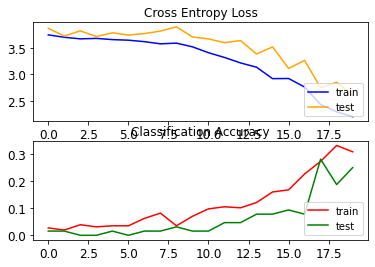

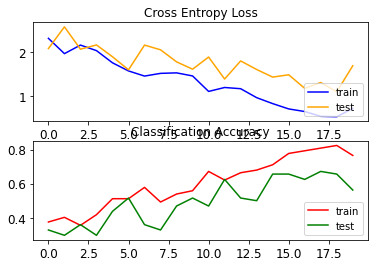

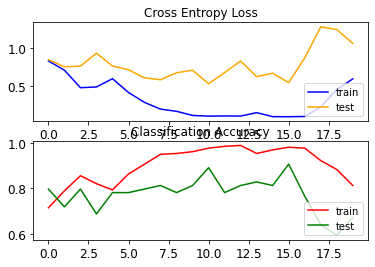

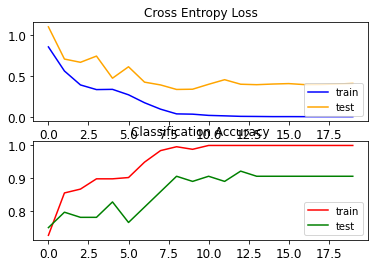

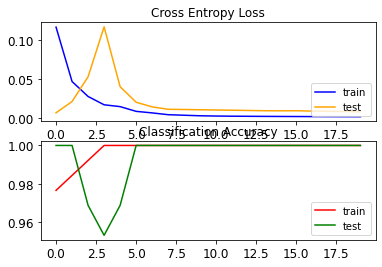

Model Accuracy: mean=67.812 std=26.546, folds=5


In [ ]:
model_1 = create_compile_model_1()
# evaluate the model
process(model_1, 5, 'model_1.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 2s 120ms/step - loss: 9.8822 - accuracy: 0.0391 - val_loss: 9.3841 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 1s 81ms/step - loss: 8.9917 - accuracy: 0.0195 - val_loss: 8.5730 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 1s 81ms/step - loss: 8.2267 - accuracy: 0.0352 - val_loss: 7.8828 - val_accuracy: 0.0312
Epoch 4/20
8/8 [==============================] - 1s 84ms/step - loss: 7.5554 - accuracy: 0.0273 - val_loss: 7.2917 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 1s 83ms/step - loss: 7.0003 - accuracy: 0.0352 - val_loss: 6.7702 - val_accuracy: 0.0000e+00
Epoch 6/20
8/8 [==============================] - 1s 82ms/step - loss: 6.5058 - accuracy: 0.0391 - val_loss: 6.3826 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 1s 95ms/step - loss: 6.1094 - accuracy: 0.0312 - val_loss: 6.0147 - val_accuracy: 0.0000e+00
Epoch 8/20
8/

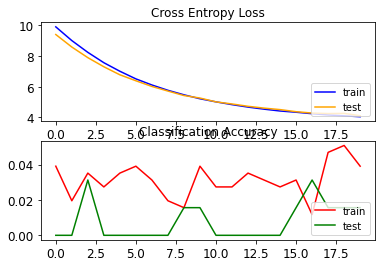

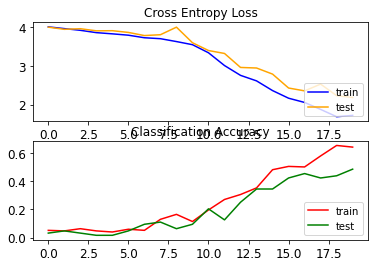

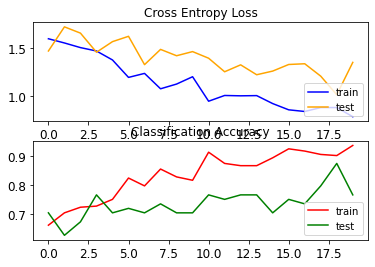

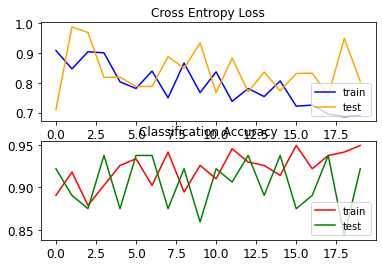

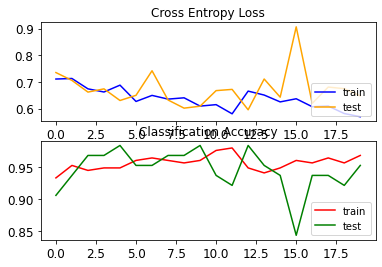

Model Accuracy: mean=64.375 std=34.762, folds=5


In [ ]:
model_2 = create_compile_model_2()
# evaluate the model
process(model_2, 5, 'model_2.h5')

# Test the model

## Evaluate & Visualize the first model  

In [ ]:
%pip install visualkeras
import visualkeras

In [ ]:
#Evaluate  the first model
model_t1 = keras.models.load_model("model_1.h5") 
model_t1.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 1.3645 - accuracy: 0.7125


[1.3645154237747192, 0.7124999761581421]

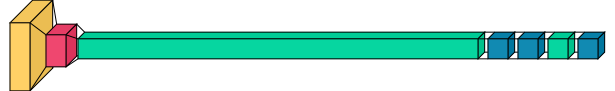

In [ ]:
visualkeras.layered_view(model_t1)

## Evaluate & Visualize the Second model  

In [ ]:

model_t2 = keras.models.load_model("model_2.h5", custom_objects={'MCDropout': MCDropout}) 
model_t2.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 1s 29ms/step - loss: 0.9559 - accuracy: 0.8500


[0.9558525085449219, 0.8500000238418579]

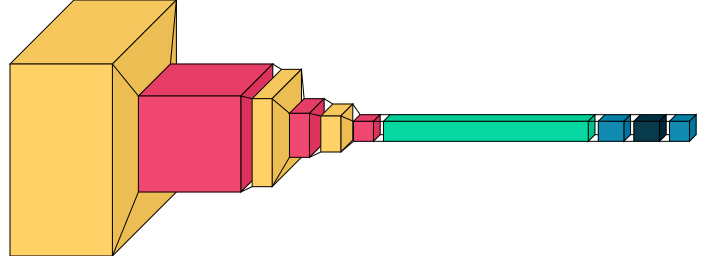

In [ ]:
visualkeras.layered_view(model_t2)

## Heat Map & Confusion Matrix for Top model 

In [ ]:
#confusion matrix.
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
pred = model_t2.predict(X_test)
cf_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
print(cf_matrix)

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


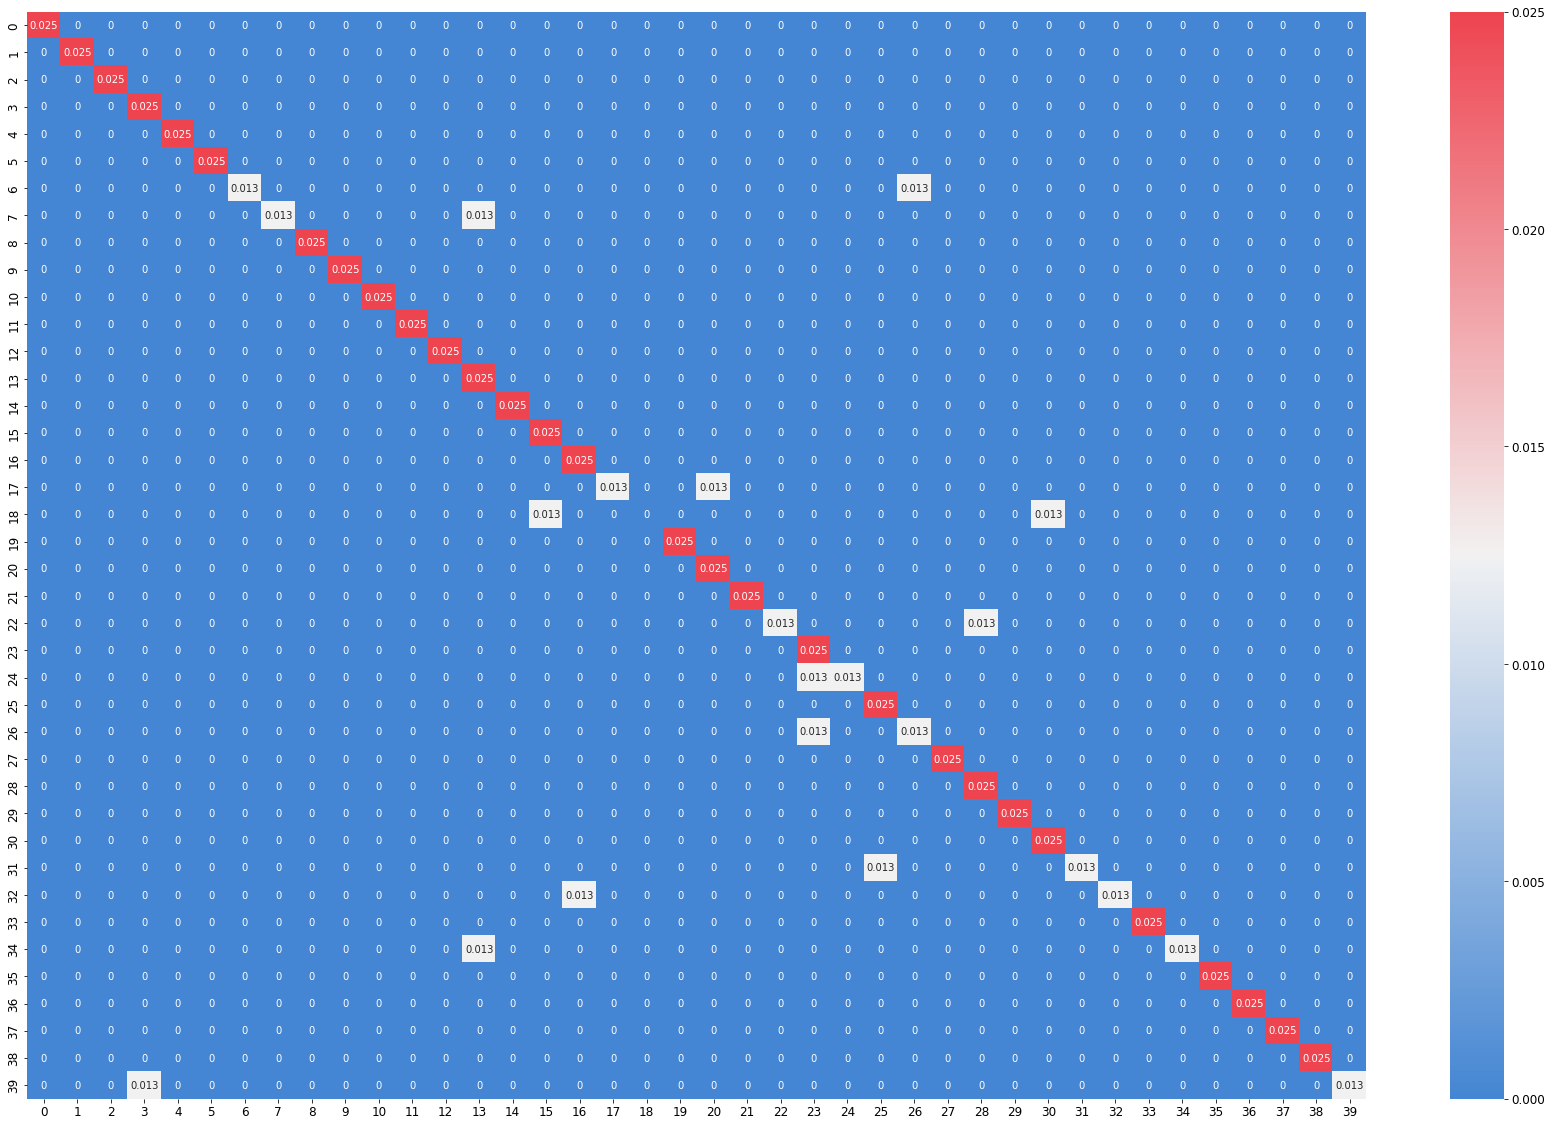

In [ ]:
plt.subplots(figsize=(30,20))

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap=cmap,annot = True, annot_kws = {'size':10}, linewidths=0)

# Experiment with Loading data Using tf.keras.utils.image_dataset_from_directory

In [ ]:
!wget https://github.com/Amruthakap3/AML/raw/main/facesDBOriginal.zip
!unzip -qq facesDBOriginal.zip

data_dir = pathlib.Path('facesDBOriginal')


ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  image_size=(48, 48),
  seed=1,
  batch_size=40)

ds_test = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(48, 48),
  batch_size=40)

for x, y in ds_train.take(1):
  print('Image --> ', x.shape, 'Label --> ',  y.shape)

for x, y in ds_test.take(1):
  print('Image --> ', x.shape, 'Label --> ',  y.shape)  

--2022-03-18 18:59:55--  https://github.com/Amruthakap3/AML/raw/main/facesDBOriginal.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Amruthakap3/AML/main/facesDBOriginal.zip [following]
--2022-03-18 18:59:55--  https://raw.githubusercontent.com/Amruthakap3/AML/main/facesDBOriginal.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1581636 (1.5M) [application/zip]
Saving to: ‘facesDBOriginal.zip’

facesDBOriginal.zip 100%[===================>]   1.51M  --.-KB/s    in 0.03s   

2022-03-18 18:59:55 (56.0 MB/s) - ‘facesDBOriginal.zip’ saved [1581636/1581636]

Found 400 files belonging to 40 cla

In [ ]:

def create_compile_model_3():
    input = tf.keras.layers.Input(shape=(48, 48, 3))
    model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(40, activation="softmax", name="pred")(x)

    # Compile
    #Using EfficientNet -> a convolutional neural network architecture and scaling method 
    #that uniformly scales all dimensions of depth/width/resolution using a compound coefficient.
    
    model = tf.keras.Model(input, output, name="EfficientNet")
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

    return model

In [ ]:
model_3 = create_compile_model_3()

history = model_3.fit(
    ds_train,
    validation_data=ds_test,
    epochs=40,
    verbose=1
)


Epoch 1/40
8/8 [==============================] - 18s 456ms/step - loss: 3.7346 - sparse_categorical_accuracy: 0.1250 - val_loss: 3.4141 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/40
8/8 [==============================] - 1s 82ms/step - loss: 2.0819 - sparse_categorical_accuracy: 0.4250 - val_loss: 3.1709 - val_sparse_categorical_accuracy: 0.3750
Epoch 3/40
8/8 [==============================] - 1s 72ms/step - loss: 1.4763 - sparse_categorical_accuracy: 0.5906 - val_loss: 2.9880 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/40
8/8 [==============================] - 1s 66ms/step - loss: 1.0812 - sparse_categorical_accuracy: 0.7188 - val_loss: 2.8390 - val_sparse_categorical_accuracy: 0.5250
Epoch 5/40
8/8 [==============================] - 1s 66ms/step - loss: 0.8597 - sparse_categorical_accuracy: 0.7812 - val_loss: 2.7216 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/40
8/8 [==============================] - 1s 66ms/step - loss: 0.6220 - sparse_categorical_accuracy: 0.84

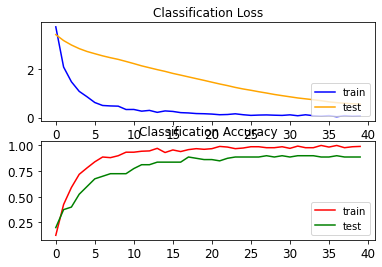

In [ ]:

# plot loss
pyplot.subplot(2, 1, 1)
pyplot.title('Classification Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(loc='lower right')
		
# plot accuracy
pyplot.subplot(2, 1, 2)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['sparse_categorical_accuracy'], color='red', label='train')
pyplot.plot(history.history['val_sparse_categorical_accuracy'], color='green', label='test')
plt.legend(loc='lower right')
  
pyplot.show()

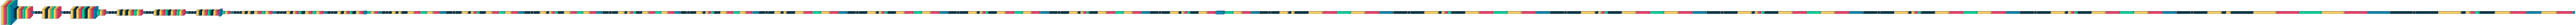

In [ ]:
visualkeras.layered_view(model_3)

# Summary 

## **Dataset**
Data contain 40 folders eatch contain 10 images, There are 400 face images in the dataset.


1.   Face images were taken at different times, variying ligthing, facial express and facial detail
2.   All face images have black or gray background
3.  The images are gray level but has 3 channel
4. image size 48x48


## **Class distributions.**

Target variable distribution is balnaced, but we have a very small dataset,
Data size is a very crucial part of training neural networks. Larger datasets can help us better learn model parameters and improve the optimization process and imparts generalization. There are two ways in which we can achieve this. We can either modify our loss function such that it can identify minute differences and learns a better representation of the data or use data augmentation. I havent used any of those techniques in this project.

## **Model**

I have used 2 modeles, i have experimented with diffrent convolution/max-pooling layers, hidden layers, dropout layers and other parameters. 
The size of the input layer depends on the size of the input data, 
some hidden layers that will allow the NN to learn complex interactions within the data and an output layer that will give the final result. The size of this layer depends on the how many classes do we want to predict, in our case we have 40 labels.


## **Training**
I’m setting the max number of epochs at 20 but in order to guard against overfitting I am going to set the training to stop when it detects that validation loss is no longer improving.



1.   Evaluate the model using k-fold cross-validation
2.   Ploted the model training loss and validation loss 
3.   Ploted the model training Accuracy  and validation Accuracy 
4.   Visualize the model
5.   Displayed Heetmap and confusion Miattrx for the best model


**Mean Accurecy**

1.   First Model : mean=67.812 std=26.546, folds=5
2.   Second Model : mean=64.375 std=34.762, folds=5

**Prediction Accurecy**

1.   First Model : loss: 1.3645 - accuracy: 0.7125
2.   Second Model : loss: 0.9559 - accuracy: 0.8500


















